In [1]:
import pycbc.waveform
from pycbc.waveform import td_approximants
import os
import matplotlib.pyplot as plt
import pylab
from pycbc.filter import match
import numpy as np
from pycbc.psd import aLIGOZeroDetHighPower
from constants import *
from tqdm import tqdm
from pycbc.waveform import get_td_waveform
from multiprocess import Pool
import pickle

from hyp_td_waveform_v2 import get_hyp_waveform

In [2]:
approximant = 'HyperbolicTD'

In [3]:
f_lower = 10
delta_t = 1./2048
inc=pi/3
#distance=1e6*pc
order=3
f_lower = 10
matchfactor=0.99
u0=0
uf=0
phase_order = -1
dist=1

In [4]:
M=40;ecc=1.2;impact=60;q=1
arrlen=50

In [5]:
hp, hc = get_td_waveform(approximant=approximant,
                                 mass1=M/2,
                                 mass2=M/2,
                                 delta_t=delta_t,
                                 hyp_eccentricity = ecc,
                                 b = impact,
                                 inclination = inc,
                                 ui = u0,
                                 uf = uf,
                                 distance = dist,
                                 phase_order = phase_order,
                                 f_lower = f_lower )

In [6]:
psd = aLIGOZeroDetHighPower(len(hc) // 2 + 1, 1.0 / hc.duration, f_lower)

In [13]:
eccs=np.linspace(1.07,1.45,arrlen)
impacts = np.linspace(40,100,arrlen)
eccs,impacts=np.meshgrid(eccs,impacts)

In [14]:
def cal_match_eb(e,b):
    
    hp2, hc2 = get_td_waveform(approximant=approximant,
                                 mass1=M/2,
                                 mass2=M/2,
                                 delta_t=delta_t,
                                 hyp_eccentricity = e,
                                 b = b,
                                 inclination = inc,
                                 ui = u0,
                                 uf = uf,
                                 distance = dist,
                                 phase_order = phase_order,
                                 f_lower = f_lower )
    #hp2,hc2=get_hyp_waveform(M,q,e, b,  delta_t, inc, distance, order)
    hc2 = hc2[:len(hc)] if len(hc) < len(hc2) else hc2
    hc2.resize(len(hc))

    m, idx = match(hc, hc2, psd=psd, low_frequency_cutoff=f_lower)
    return m

In [15]:
import os
fn='file_M_'+str(M)+'_ref_M'+str(ecc)+'b_'+str(impact)+'_hc2_LAL.pkl'
os.remove(fn) if os.path.exists(fn) else None  #here fn - filename or filepath

In [16]:
ncore=8
arr2=np.zeros((arrlen,arrlen))

peakfile = open(fn, 'ab')


if __name__ == "__main__":

    pool = Pool(ncore)
    results = pool.map(lambda t : cal_match_eb(t[0],t[1]), 
                       [(eccs[i][j],impacts[i][j])
                        for i in range(arrlen) for j in range(arrlen)] )

    pickle.dump(np.array(results).reshape((arrlen,arrlen)),peakfile)
    peakfile.close()

In [19]:
arr2 = pickle.load(open(fn, 'rb'))

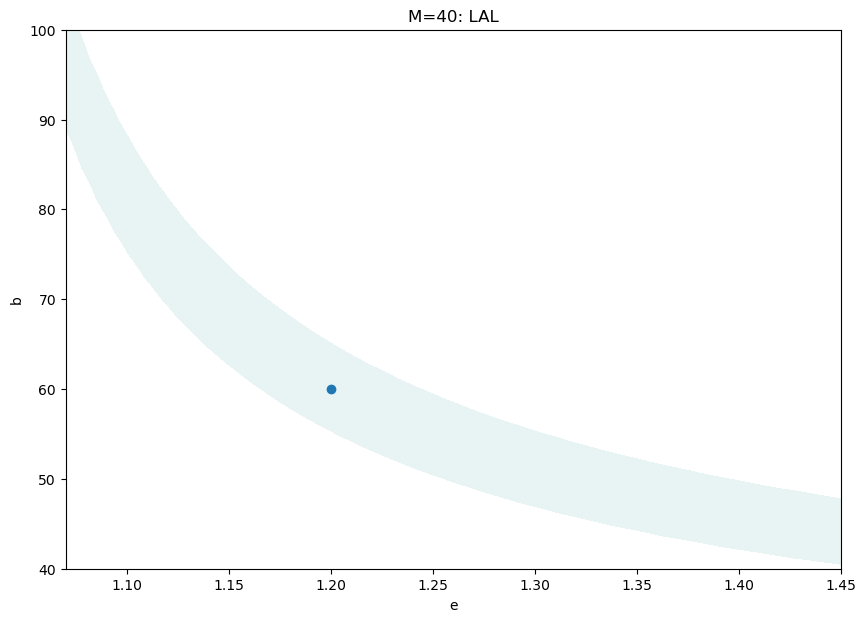

In [39]:
fig1=plt.figure(figsize=(10,7))
plt.contourf(eccs, impacts, arr2,[0.99,1],alpha=0.1)
plt.scatter(ecc,impact)
plt.xlabel('e')
plt.ylabel('b')
plt.title('M='+str(M)+': LAL')
plt.savefig('file_M_'+str(M)+'_ref_M'+str(ecc)+'b_'+str(impact)+'_hc2_LAL.png',dpi=300)
plt.show()

In [21]:
arr3 = pickle.load(open('file_M_'+str(M)+'_ref_M'+str(ecc)+'b_'+str(impact)+'_hc2.pkl', 'rb'))

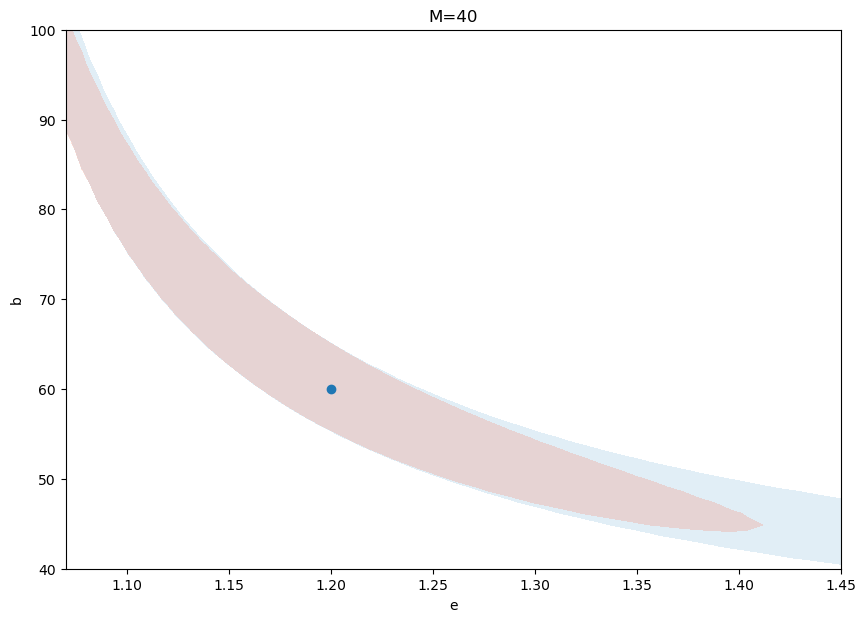

In [38]:
fig1=plt.figure(figsize=(10,7))
plt.contourf(eccs, impacts, arr2,[0.99,1],alpha=0.2,cmap='Blues')
plt.contourf(eccs, impacts, arr3,[0.99,1],alpha=0.2,cmap='Reds')
plt.scatter(ecc,impact)
plt.xlabel('e')
plt.ylabel('b')
plt.title('M='+str(M))
plt.savefig('file_M_'+str(M)+'_ref_M'+str(ecc)+'b_'+str(impact)+'_hc2.png',dpi=300)
plt.show()